In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import joblib

In [6]:
class HousePriceForecaster:
    def __init__(self, data_path):
        self.df = pd.read_csv(data_path)
        self.df['YearMonth'] = pd.to_datetime(self.df['YearMonth'])
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = None
        
    def prepare_data(self, zipcode):
        zipcode_data = self.df[self.df['zipcode'] == zipcode].sort_values('YearMonth').set_index('YearMonth')
        return zipcode_data
    
    def create_features(self, data):
        data['month'] = data.index.month
        data['year'] = data.index.year
        return data
    
    def split_data(self, data):
        self.feature_names = ['NoiseComplaints', 'distance_to_facility', 'cultural_facility', 'education_facility', 
                    'health_services', 'recreational_facility', 'religious_institution', 
                    'transportation_facility', 'population', 'average_household_income',
                    'month', 'year']
        X = data[self.feature_names]
        y = data['AveragePrice']
        return train_test_split(X, y, test_size=0.2, shuffle=False)
    
    def train_model(self, X_train, y_train):
        X_train_scaled = self.scaler.fit_transform(X_train)
        self.model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        self.model.fit(X_train_scaled, y_train)
    
    def evaluate_model(self, X_test, y_test):
        X_test_scaled = self.scaler.transform(X_test)
        y_pred = self.model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mae, r2
    
    def forecast(self, data, steps=60):
        last_date = data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')
        future_df = pd.DataFrame(index=future_dates)
        future_df['month'] = future_df.index.month
        future_df['year'] = future_df.index.year
        
        for col in self.feature_names:
            if col not in ['month', 'year']:
                future_df[col] = data[col].iloc[-1]
        
        future_X = future_df[self.feature_names]
        future_X_scaled = self.scaler.transform(future_X)
        forecast = self.model.predict(future_X_scaled)
        
        return pd.Series(forecast, index=future_dates)
    
    def calculate_roi(self, current_price, future_price):
        return (future_price - current_price) / current_price
    
    def get_top_zipcodes(self, borough, max_price, years=[1, 3, 5]):
        borough_data = self.df[self.df['Borough'] == borough]
        affordable_zipcodes = borough_data[borough_data['AveragePrice'] <= max_price]['zipcode'].unique()
        
        results = []
        for zipcode in affordable_zipcodes:
            zipcode_data = self.prepare_data(zipcode)
            if len(zipcode_data) < 24: 
                continue
            
            data_with_features = self.create_features(zipcode_data)
            X_train, X_test, y_train, y_test = self.split_data(data_with_features)
            
            self.train_model(X_train, y_train)
            mae, r2 = self.evaluate_model(X_test, y_test)
            
            current_price = zipcode_data['AveragePrice'].iloc[-1]
            forecast = self.forecast(data_with_features)
            
            roi_results = {}
            for year in years:
                future_price = forecast.iloc[12*year - 1]
                roi = self.calculate_roi(current_price, future_price)
                roi_results[f'{year}Yr_ROI'] = roi
            
            results.append({
                'zipcode': zipcode,
                'current_price': current_price,
                'mae': mae,
                'r2': r2,
                **roi_results
            })
        
        results_df = pd.DataFrame(results)
        return results_df.nlargest(5, '5Yr_ROI')
    
    def plot_forecast(self, zipcode):
        data = self.prepare_data(zipcode)
        data_with_features = self.create_features(data)
        X_train, X_test, y_train, y_test = self.split_data(data_with_features)
        self.train_model(X_train, y_train)
        forecast = self.forecast(data_with_features)
        
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data['AveragePrice'], label='Historical')
        plt.plot(forecast.index, forecast, label='Forecast')
        plt.title(f'Housing Price Forecast for Zipcode {zipcode}')
        plt.xlabel('Date')
        plt.ylabel('Average Price')
        plt.legend()
        plt.show()
    
    def plot_feature_importance(self, zipcode):
        data = self.prepare_data(zipcode)
        data_with_features = self.create_features(data)
        X_train, X_test, y_train, y_test = self.split_data(data_with_features)
        self.train_model(X_train, y_train)
        
        importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importance)
        plt.title(f'Feature Importance for Zipcode {zipcode}')
        plt.show()
    
    def save_model(self, filepath):
        joblib.dump((self.model, self.scaler, self.feature_names), filepath)
    
    def load_model(self, filepath):
        self.model, self.scaler, self.feature_names = joblib.load(filepath)

C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')
C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')
C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')
C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(star

Top 5 Zipcodes in Manhattan under $2,000,000:
    zipcode  current_price            mae        r2   1Yr_ROI   3Yr_ROI  \
26    10035         599463  245542.013889 -1.240896  0.912050  0.912050   
0     10001        1675072  574094.203704 -1.050088  0.726951  0.726951   
18    10027         781983  212605.976852 -0.872304  0.589286  0.589286   
8     10014        1628708  362856.611111 -1.203417  0.474074  0.474074   
11    10018        1306133  280840.578704 -1.462348  0.422026  0.422026   

     5Yr_ROI  
26  0.912050  
0   0.726951  
18  0.589286  
8   0.474074  
11  0.422026  


C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')


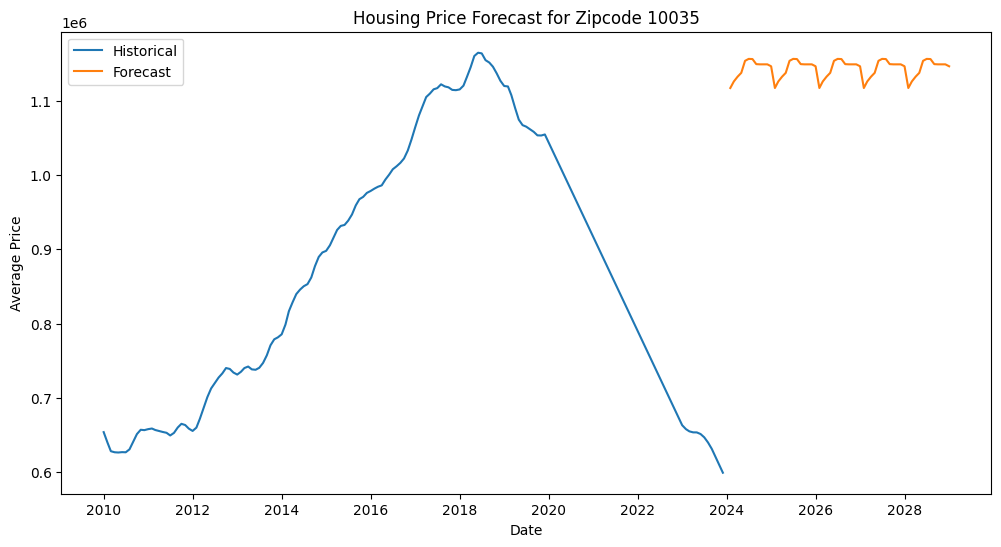

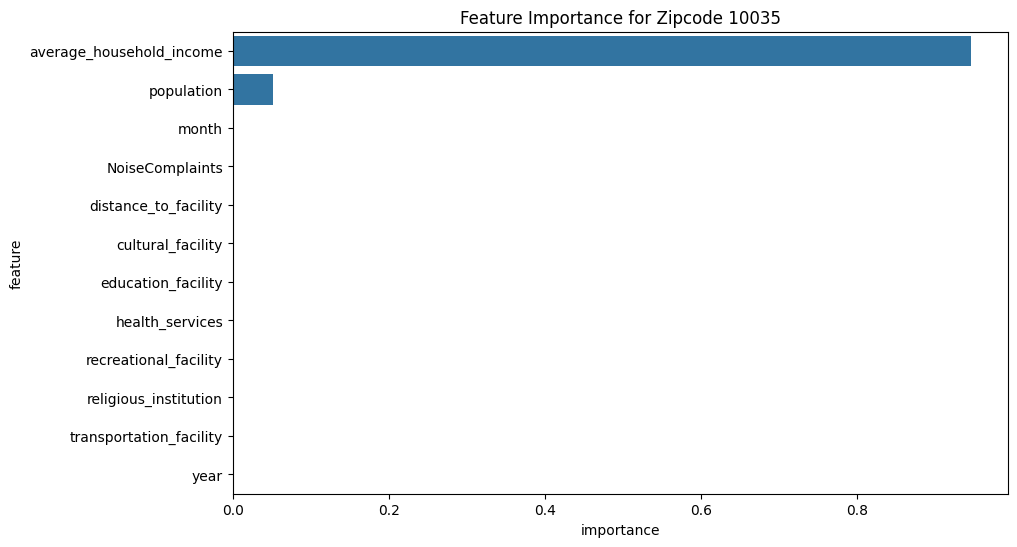

C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')


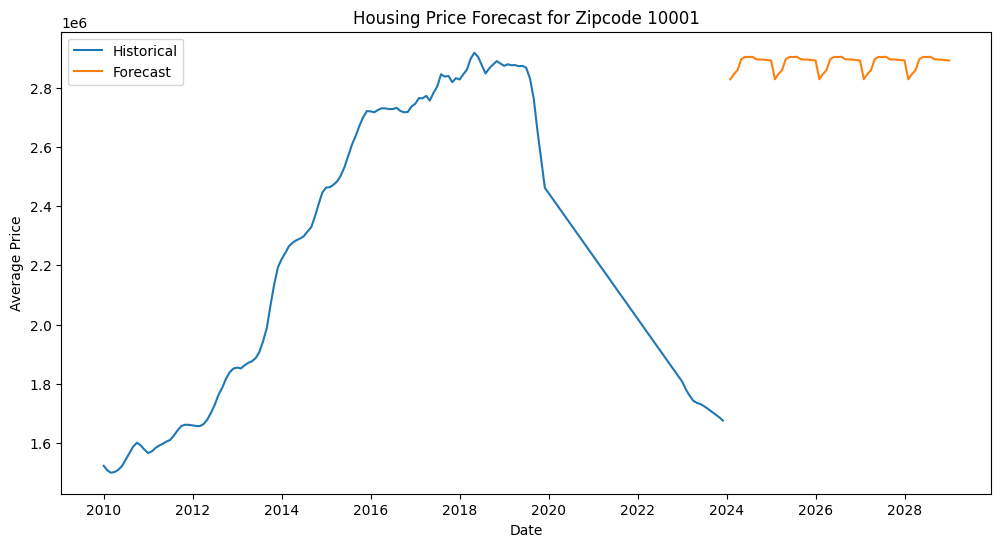

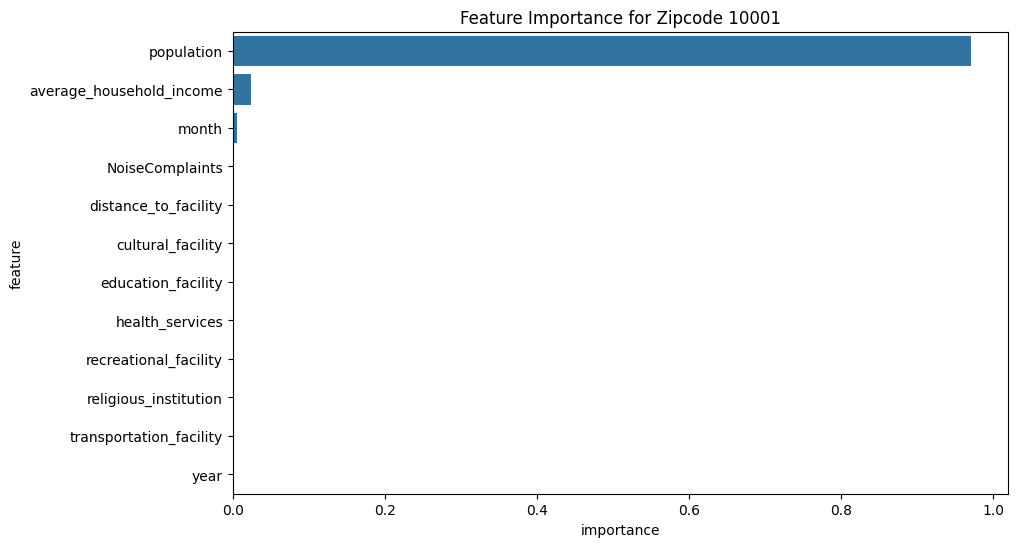

C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')


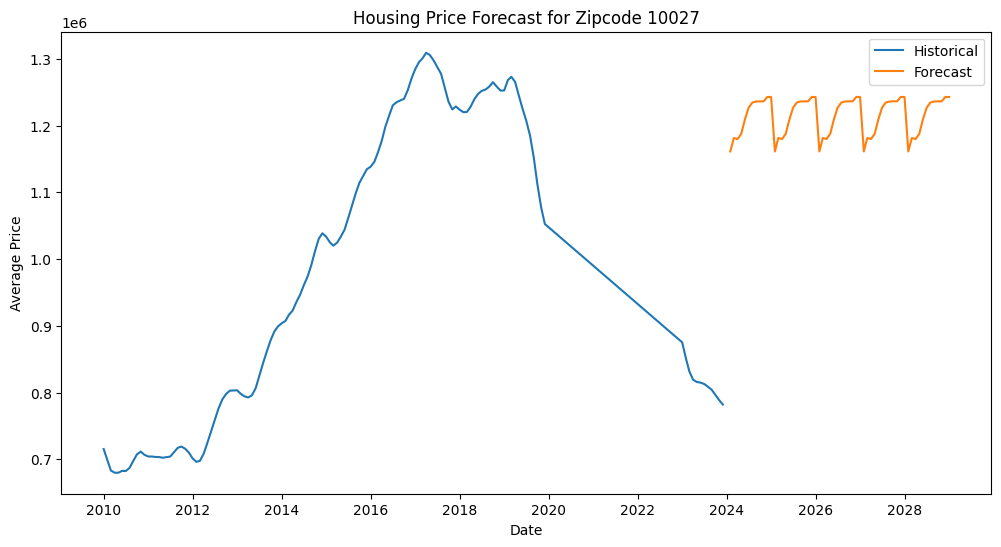

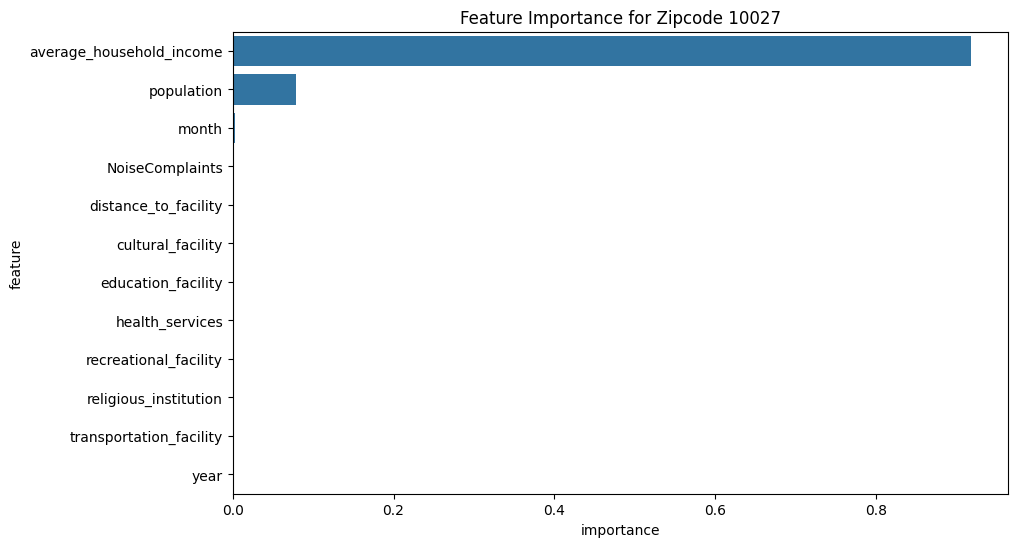

C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')


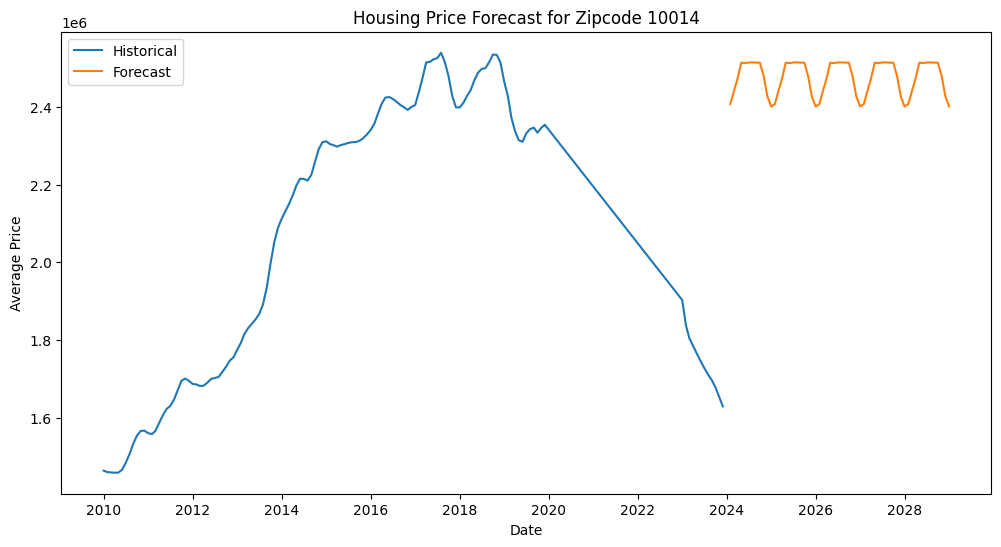

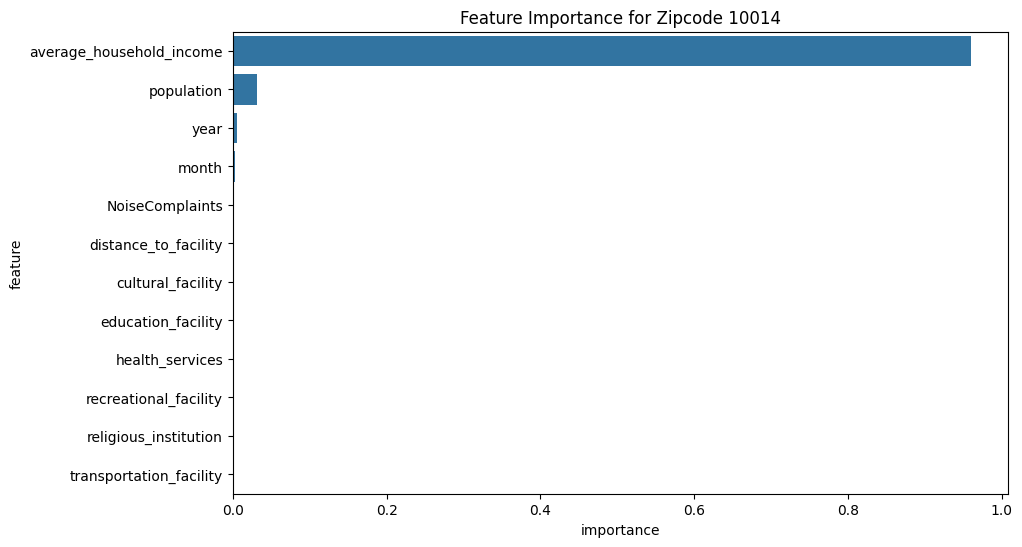

C:\Users\simon\AppData\Local\Temp\ipykernel_28428\2747142394.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M')


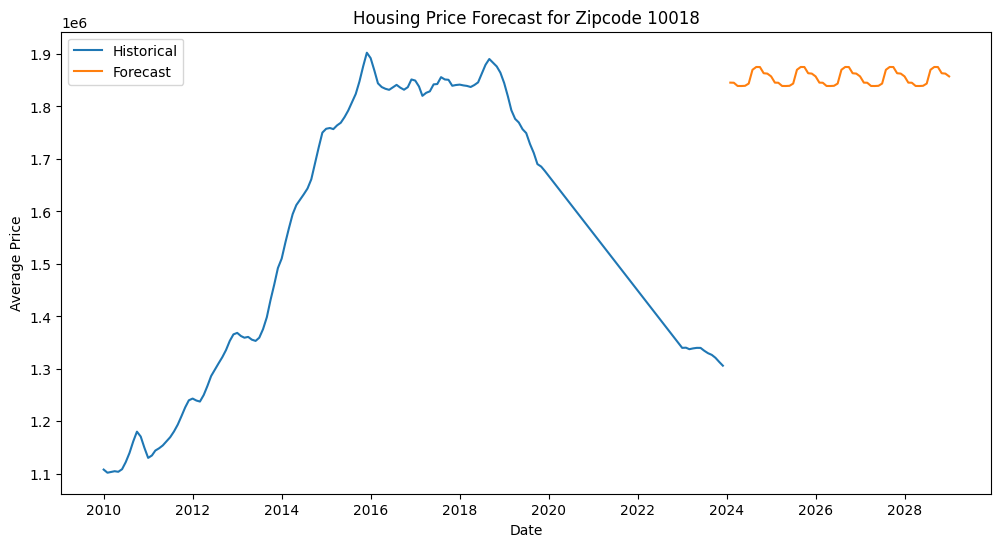

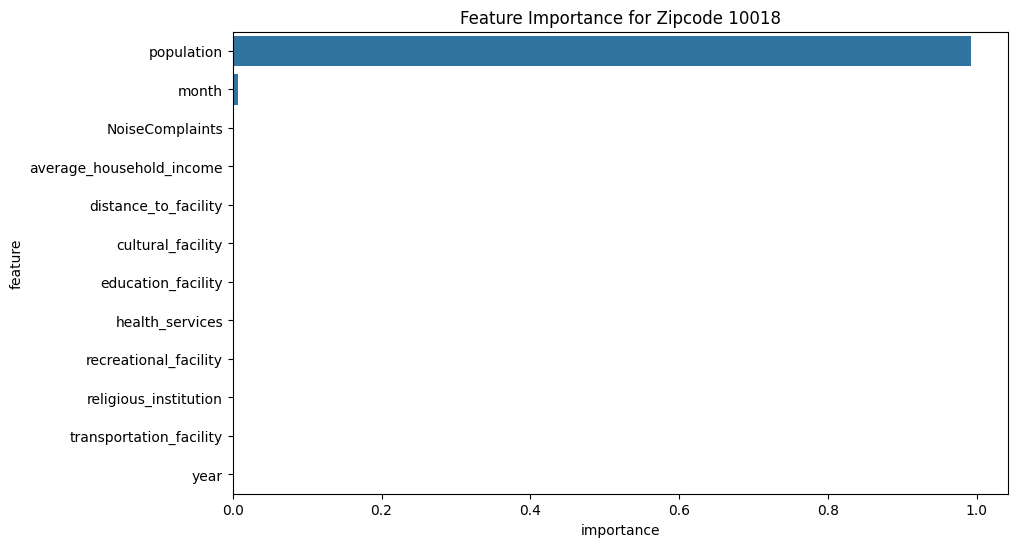

In [7]:
# Example usage
forecaster = HousePriceForecaster('training_data.csv')
borough = 'Manhattan'
max_price = 2000000

top_zipcodes = forecaster.get_top_zipcodes(borough, max_price)
print(f"Top 5 Zipcodes in {borough} under ${max_price:,}:")
print(top_zipcodes)

for zipcode in top_zipcodes['zipcode']:
    forecaster.plot_forecast(zipcode)
    forecaster.plot_feature_importance(zipcode)

forecaster.save_model(f'model_{zipcode}.joblib')

# To load the model later:
# forecaster.load_model(f'model_{zipcode}.joblib')